<a href="https://colab.research.google.com/github/OlgaNezh/Computer_Vision/blob/main/CV_HW_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Обучить сиамскую сеть для верификации лиц на датасете LFW
Библиотеки: [Python, Tensorflow]


In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
(ds_train, ds_test), ds_info = tfds.load('lfw',
                                         split=['train[:80%]', 'train[80%:]'], 
                                         as_supervised=True, 
                                         with_info=True) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/13233 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/lfw/0.1.0.incompleteOPG839/lfw-train.tfrecord*...:   0%|          | 0/13233 [0…

Dataset lfw downloaded and prepared to ~/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [4]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
    'label': Text(shape=(), dtype=tf.string),
})

In [5]:
ds_train

<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(250, 250, 3), dtype=tf.uint8, name=None))>

In [6]:
len(ds_train), len(ds_test)

(10586, 2647)

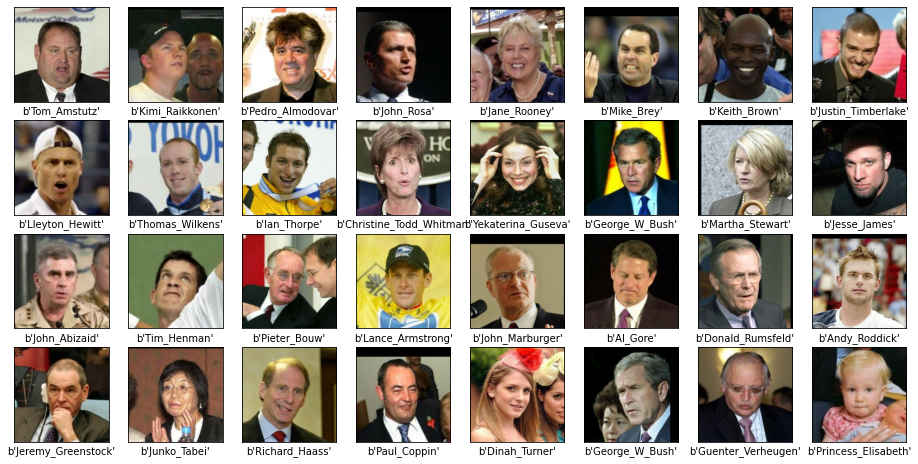

In [7]:
ds_train_np = tfds.as_numpy(ds_train.take(32)) #tf.data.Dataset -> Iterator[Tree[np.array]] 
fig = plt.figure(figsize=(16, 8))
j = 0
for label, image in ds_train_np:
  ax = fig.add_subplot(4, 8, j+1)
  ax.imshow(image)
  plt.xticks([]), plt.yticks([])
  plt.xlabel(str(label))
  j += 1
plt.show()


### Подготовка пайплайна данных <a id='section_1'></a>

In [8]:
INP_SIZE = 250
NUM_EPOCHS = 5
BATCH_SIZE = 32

def preprocessing(img):
    img = tf.cast(img, tf.float32)/255.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE))

train_ds = ds_train.shuffle(buffer_size=len(ds_train))
train_ds = train_ds.map(lambda label, img: (preprocessing(img), label))
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = ds_test.shuffle(buffer_size=len(ds_test))
test_ds = test_ds.map(lambda label, img: (preprocessing(img), label))
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

In [9]:
train_ds, len(train_ds)

(<BatchDataset element_spec=(TensorSpec(shape=(32, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32,), dtype=tf.string, name=None))>,
 1654)

### Создание модели CNN <a id='section_2'></a>

In [10]:
EMB_SIZE = 128

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

### Contrastive Loss

In [11]:
MARGIN = 10.0

def contrastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]
    
    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)

    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [12]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

### Обучение модели <a id='section_3'></a>

In [24]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contrastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))


[0] Loss: 89.08146667480469
[200] Loss: 0.0
[400] Loss: 0.08401578664779663
[600] Loss: 0.0
[800] Loss: 0.0
[1000] Loss: 0.0
[1200] Loss: 1.005781650543213
[1400] Loss: 0.0
[1600] Loss: 0.1797376573085785
CPU times: user 1min 37s, sys: 11 s, total: 1min 48s
Wall time: 3min 21s


### Тестирование модели на новых данных <a id='section_4'></a>

In [25]:
person_1 = b'Arnold_Schwarzenegger'
person_2 = b'Tom_Hanks'

In [26]:
test_img_list_A = [image for label, image in ds_test if label.numpy() == person_1] [:2]
test_img_list_B = [image for label, image in ds_test if label.numpy() == person_2][:1]
img_a1 = preprocessing(test_img_list_A[0])
img_a2 = preprocessing(test_img_list_A[1])
img_b1 = preprocessing(test_img_list_B[0])

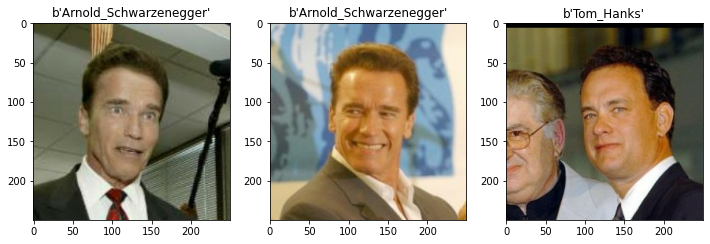

In [27]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1)
plt.title(person_1)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2)
plt.title(person_1)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1)
plt.title(person_2)
plt.show()

### Получение эмбеддингов для новых данных


In [28]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0)) 

In [29]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print(f'{person_1}_1 <-> {person_1}_2: ', diff(emb1, emb2))
print(f'{person_1}_1 <-> {person_2}_1: ', diff(emb1, emb3))
print(f'{person_1}_2 <-> {person_2}_1: ', diff(emb2, emb3))

b'Arnold_Schwarzenegger'_1 <-> b'Arnold_Schwarzenegger'_2:  15.321707810313098
b'Arnold_Schwarzenegger'_1 <-> b'Tom_Hanks'_1:  17.04810930883127
b'Arnold_Schwarzenegger'_2 <-> b'Tom_Hanks'_1:  23.941896677245648


In [30]:
person_1 = b'Carson_Daly'
person_2 = b'Donna_Barrera'

In [31]:
test_img_list_A = [image for label, image in ds_test if label.numpy() == person_1] [:2]
test_img_list_B = [image for label, image in ds_test if label.numpy() == person_2][:1]
img_a1 = preprocessing(test_img_list_A[0])
img_a2 = preprocessing(test_img_list_A[1])
img_b1 = preprocessing(test_img_list_B[0])

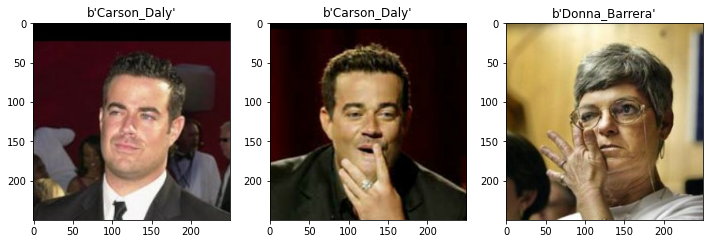

In [32]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1)
plt.title(person_1)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2)
plt.title(person_1)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1)
plt.title(person_2)
plt.show()

In [33]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0)) 

In [34]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print(f'{person_1}_1 <-> {person_1}_2: ', diff(emb1, emb2))
print(f'{person_1}_1 <-> {person_2}_1: ', diff(emb1, emb3))
print(f'{person_1}_2 <-> {person_2}_1: ', diff(emb2, emb3))

b'Carson_Daly'_1 <-> b'Carson_Daly'_2:  14.00551060806346
b'Carson_Daly'_1 <-> b'Donna_Barrera'_1:  22.324822621425795
b'Carson_Daly'_2 <-> b'Donna_Barrera'_1:  16.462070217909258
